## Experimento No 5 - Feature Engineering & Feature Selection

**Notes:**

- **Feature engineering** is the process of creating more meaningful features for the model
- **Feature Selection** is the process of selecting the best features for the model without changing their original value.

### Load data and import libraries

In [1]:
# In case you're running this in colab
# !pip install pycaret
# !pip install dython
# !pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
import warnings
%matplotlib inline

from sklearn.preprocessing import TargetEncoder, LabelEncoder, OrdinalEncoder
from pycaret.classification import setup, compare_models
import joblib
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2

RANDOM_SEED = 42 # For reproducibility

sns.set_palette('dark')
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)

In [3]:
df_train_full = pd.read_csv('data/train.csv')
df_test_full = pd.read_csv('data/test.csv')
df_train_full.head().T

,0,1,2,3,4
ID,904256,645256,308367,470353,989032
PERIODO,20212,20212,20203,20195,20212
ESTU_PRGM_ACADEMICO,ENFERMERIA,DERECHO,MERCADEO Y PUBLICIDAD,ADMINISTRACION DE EMPRESAS,PSICOLOGIA
ESTU_PRGM_DEPARTAMENTO,BOGOTÁ,ATLANTICO,BOGOTÁ,SANTANDER,ANTIOQUIA
ESTU_VALORMATRICULAUNIVERSIDAD,Entre 5.5 millones y menos de 7 millones,Entre 2.5 millones y menos de 4 millones,Entre 2.5 millones y menos de 4 millones,Entre 4 millones y menos de 5.5 millones,Entre 2.5 millones y menos de 4 millones
ESTU_HORASSEMANATRABAJA,Menos de 10 horas,0,Más de 30 horas,0,Entre 21 y 30 horas
FAMI_ESTRATOVIVIENDA,Estrato 3,Estrato 3,Estrato 3,Estrato 4,Estrato 3
FAMI_TIENEINTERNET,Si,No,Si,Si,Si
FAMI_EDUCACIONPADRE,Técnica o tecnológica incompleta,Técnica o tecnológica completa,Secundaria (Bachillerato) completa,No sabe,Primaria completa
FAMI_TIENELAVADORA,Si,Si,Si,Si,Si


In [4]:
df_train_full.shape

(692500, 17)

### EDA

In [5]:
df_analysis = df_train_full.copy()
df_analysis.drop('ID', axis=1, inplace=True)
df_analysis['PERIODO'] = df_analysis['PERIODO'].astype(str).apply(lambda text: text[:4])

df_analysis.isna().sum()

PERIODO                               0
ESTU_PRGM_ACADEMICO                   0
ESTU_PRGM_DEPARTAMENTO                0
ESTU_VALORMATRICULAUNIVERSIDAD     6287
ESTU_HORASSEMANATRABAJA           30857
FAMI_ESTRATOVIVIENDA              32137
FAMI_TIENEINTERNET                26629
FAMI_EDUCACIONPADRE               23178
FAMI_TIENELAVADORA                39773
FAMI_TIENEAUTOMOVIL               43623
ESTU_PRIVADO_LIBERTAD                 0
ESTU_PAGOMATRICULAPROPIO           6498
FAMI_TIENECOMPUTADOR              38103
FAMI_TIENEINTERNET.1              26629
FAMI_EDUCACIONMADRE               23664
RENDIMIENTO_GLOBAL                    0
dtype: int64

In [6]:
df_analysis.describe(include='object')

,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL
count,692500,692500,692500,686213,661643,660363,665871,669322,652727,648877,692500,686002,654397,665871,668836,692500
unique,4,948,31,8,5,7,2,12,2,2,2,2,2,2,12,4
top,2019,DERECHO,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Más de 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,alto
freq,182510,53244,282159,204048,249352,232671,592514,128289,563390,412606,692466,382201,597670,592514,141744,175619


In [7]:
df_analysis['FAMI_EDUCACIONMADRE'].unique()

array(['Postgrado', 'Técnica o tecnológica incompleta',
       'Secundaria (Bachillerato) completa', 'Primaria completa',
       'Técnica o tecnológica completa',
       'Secundaria (Bachillerato) incompleta',
       'Educación profesional incompleta',
       'Educación profesional completa', 'Primaria incompleta', nan,
       'Ninguno', 'No Aplica', 'No sabe'], dtype=object)

In [8]:
df_analysis['FAMI_ESTRATOVIVIENDA'].unique()

array(['Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 2', 'Estrato 1',
       nan, 'Estrato 6', 'Sin Estrato'], dtype=object)

In [9]:
df_analysis['ESTU_VALORMATRICULAUNIVERSIDAD'].value_counts()

ESTU_VALORMATRICULAUNIVERSIDAD
Entre 1 millón y menos de 2.5 millones      204048
Entre 2.5 millones y menos de 4 millones    127430
Menos de 500 mil                             80263
Entre 500 mil y menos de 1 millón            78704
Entre 4 millones y menos de 5.5 millones     69736
Más de 7 millones                            68014
Entre 5.5 millones y menos de 7 millones     38490
No pagó matrícula                            19528
Name: count, dtype: int64

In [10]:
df_analysis['ESTU_HORASSEMANATRABAJA'].value_counts()

ESTU_HORASSEMANATRABAJA
Más de 30 horas        249352
0                      116550
Entre 11 y 20 horas    115857
Entre 21 y 30 horas     92693
Menos de 10 horas       87191
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='ESTU_VALORMATRICULAUNIVERSIDAD'>

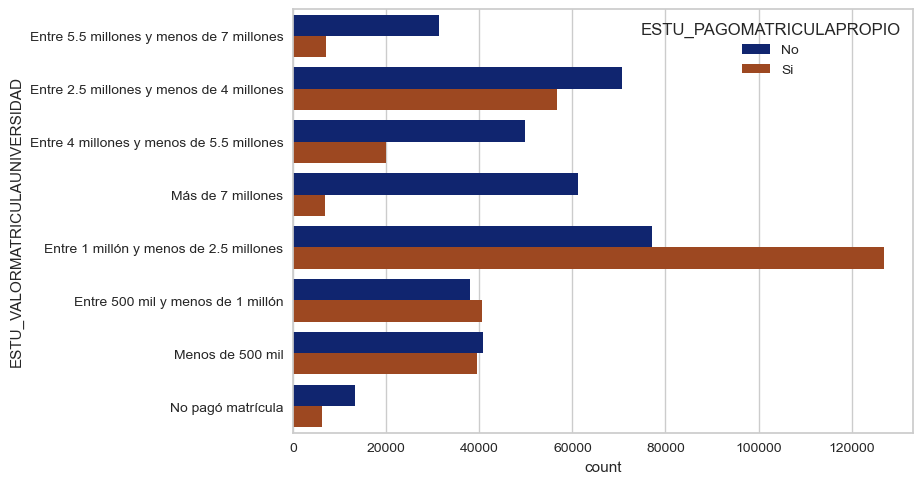

In [11]:
sns.countplot(df_analysis, y='ESTU_VALORMATRICULAUNIVERSIDAD', hue='ESTU_PAGOMATRICULAPROPIO')

### Correlation Pre-processing

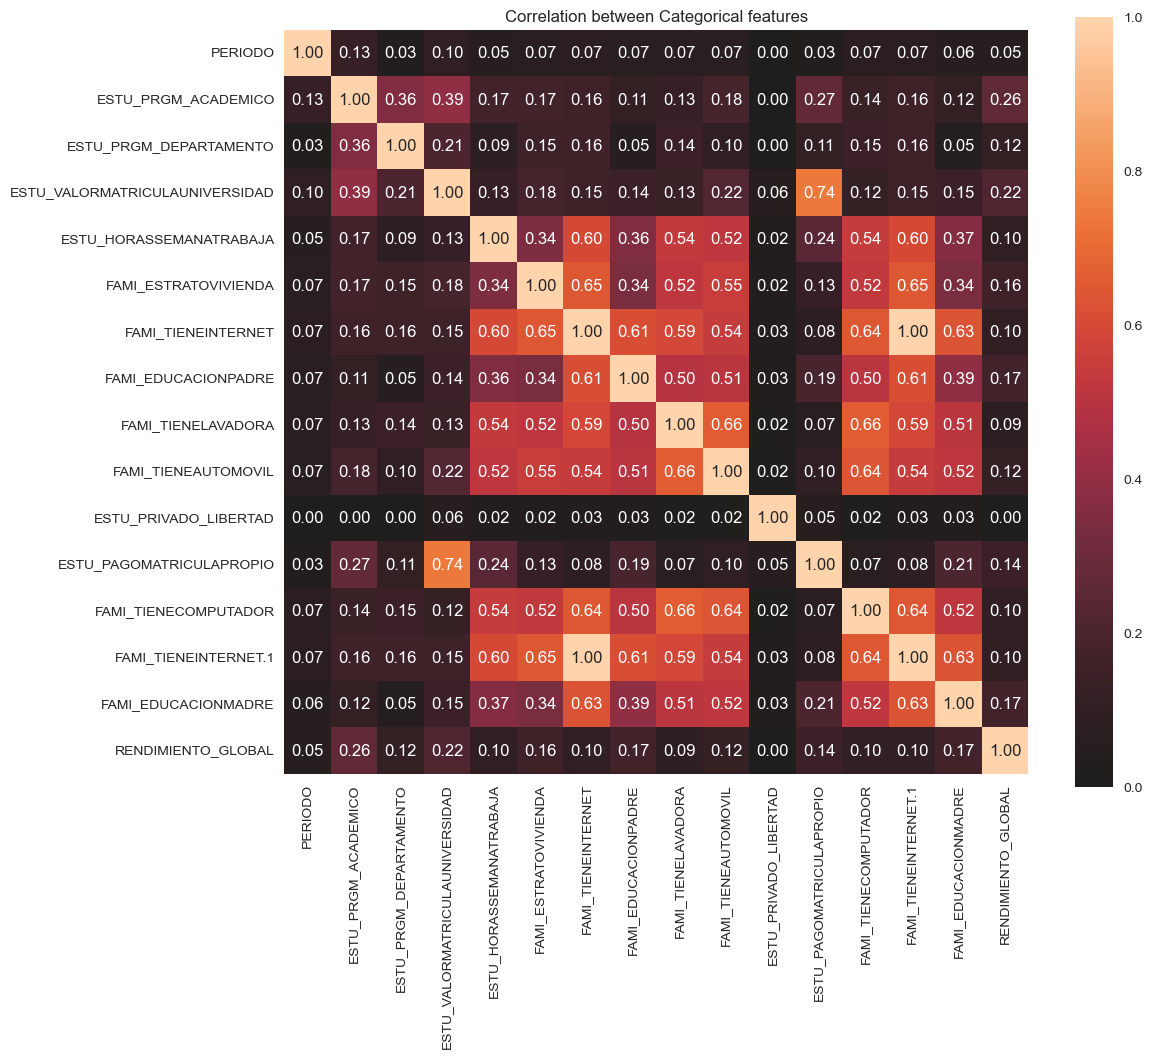

In [12]:
associations(df_analysis, figsize=(12, 10), title='Correlation between Categorical features')
plt.show()

### Preprocessing

#### Cleaning Features
- Drop `ID` and `FAMI_TIENEINTERNET.1` which is duplicated
- Remove weird characters in `ESTU_PGRM_ACADEMICO`, group rare values into one category
- Do feature engineering to `EDUCACIONPADRE - MADRE` **(Next experiment)**
- Replace 0 for 'No trabaja' in `ESTU_HORASSEMANATRABAJA`


In [13]:
def clean_data(df: pd.DataFrame): 
    new_df = df.copy() # Create a copy

    # Drop and clean columns
    new_df.drop(['ID', 'FAMI_TIENEINTERNET.1'], axis=1, inplace=True)
    new_df['PERIODO'] = new_df['PERIODO'].astype(str).apply(lambda text: text[:4])

    return new_df

# Clean data in both train and test
df_train = clean_data(df_train_full)
df_test = clean_data(df_test_full)

In [14]:
def normalize_text(text: str):
    """Removes any weird character like accents from a string"""
    import unicodedata

    if not pd.isna(text):
        return (
            unicodedata.normalize('NFKD', text)
            .encode('ASCII', 'ignore')
            .decode('utf-8')
        )
    return text

def group_rare_values(data: pd.DataFrame, col: str, threshold: float = 0.01):
    """Groups rare values into a unique category"""
    percentajes = data[col].value_counts(normalize=True)
    group_values = lambda value: 'OTRO' if percentajes[value] < threshold else value

    return data[col].apply(group_values)
    

# Remove weird characters from values
for col in ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']:
    df_train[col] = df_train[col].apply(normalize_text)
    df_test[col] = df_test[col].apply(normalize_text)

# Group rare values into one category
for col in ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO']:
    df_train[col] = group_rare_values(df_train, col)
    df_test[col] = group_rare_values(df_test, col)

In [15]:
# Replace values to make more sense
df_train['ESTU_HORASSEMANATRABAJA'].replace('0', 'No trabaja', inplace=True)
df_train['FAMI_EDUCACIONPADRE'].replace(['No Aplica', 'No sabe'], 'Ninguno', inplace=True)
df_train['FAMI_EDUCACIONMADRE'].replace(['No Aplica', 'No sabe'], 'Ninguno', inplace=True)

df_test['ESTU_HORASSEMANATRABAJA'].replace('0', 'No trabaja', inplace=True)
df_test['FAMI_EDUCACIONPADRE'].replace(['No Aplica', 'No sabe'], 'Ninguno', inplace=True)
df_test['FAMI_EDUCACIONMADRE'].replace(['No Aplica', 'No sabe'], 'Ninguno', inplace=True)

#### Imputation
- There's only 6 social classes in Colombia, therefore we can use 'Sin Estrato' or mode
- Use mode for Binary Features
- Use 'No trabaja' for `ESTU_HORASSEMANATRABAJA`
- Use 'Ninguno' for `EDUCACIONPADRE - MADRE`
- Use mode for `MATRICULA` (this can change to 'No pago matricula')

In [16]:
def impute_cols(df: pd.DataFrame):
    new_df = df.copy() # Make a copy

    # Impute with own values
    new_df['FAMI_ESTRATOVIVIENDA'] = new_df['FAMI_ESTRATOVIVIENDA'].fillna('Sin Estrato')
    new_df['ESTU_HORASSEMANATRABAJA'] = new_df['ESTU_HORASSEMANATRABAJA'].fillna('No trabaja')
    new_df['FAMI_EDUCACIONPADRE'] = new_df['FAMI_EDUCACIONPADRE'].fillna('Ninguno')
    new_df['FAMI_EDUCACIONMADRE'] = new_df['FAMI_EDUCACIONMADRE'].fillna('Ninguno')

    # Select binary columns
    binary_cols = [col for col in new_df.columns if new_df[col].nunique() == 2]
    for col in binary_cols + ['ESTU_VALORMATRICULAUNIVERSIDAD']:
        col_mode = new_df[col].mode()[0]
        new_df[col] = new_df[col].fillna(col_mode)

    return new_df

df_imputed = impute_cols(df_train)

In [17]:
df_imputed.isna().sum().sum() # Verify is all values were imputed

0

In [18]:
# Impute values in training and testing datasets
df_train = impute_cols(df_train)
df_test = impute_cols(df_test)

### Feature engineering

In [19]:
import re

def handle_parent_education(text: str) -> str:
    """Handles and assigns the correct education of a person."""
    pattern = r'.* (completa|incompleta)'
    matches = re.search(pattern, text)
    superior_education = ['Postgrado', 'profesional', 'Tecnica']

    if matches:
        if 'completa' == matches.group(1):
            # Check if at least one level is in text
            if any(level in text for level in superior_education):
                text = 'Superior'
            elif 'Secundaria' in text:
                text = 'Media'
            elif 'Primaria' in text:
                text = 'Basica'
        elif 'incompleta' == matches.group(1):
            if any(level in text for level in superior_education):
                text = 'Media'
            elif 'Secundaria' in text:
                text = 'Basica'
            elif 'Primaria' in text:
                text = 'Ninguno'

    if text == 'Postgrado':
        text = 'Superior'

    return text

In [20]:
# Map new values to the columns
df_train['FAMI_EDUCACIONMADRE'] = df_train['FAMI_EDUCACIONMADRE'].apply(handle_parent_education)
df_train['FAMI_EDUCACIONPADRE'] = df_train['FAMI_EDUCACIONPADRE'].apply(handle_parent_education)

df_test['FAMI_EDUCACIONMADRE'] = df_test['FAMI_EDUCACIONMADRE'].apply(handle_parent_education)
df_test['FAMI_EDUCACIONPADRE'] = df_test['FAMI_EDUCACIONPADRE'].apply(handle_parent_education)

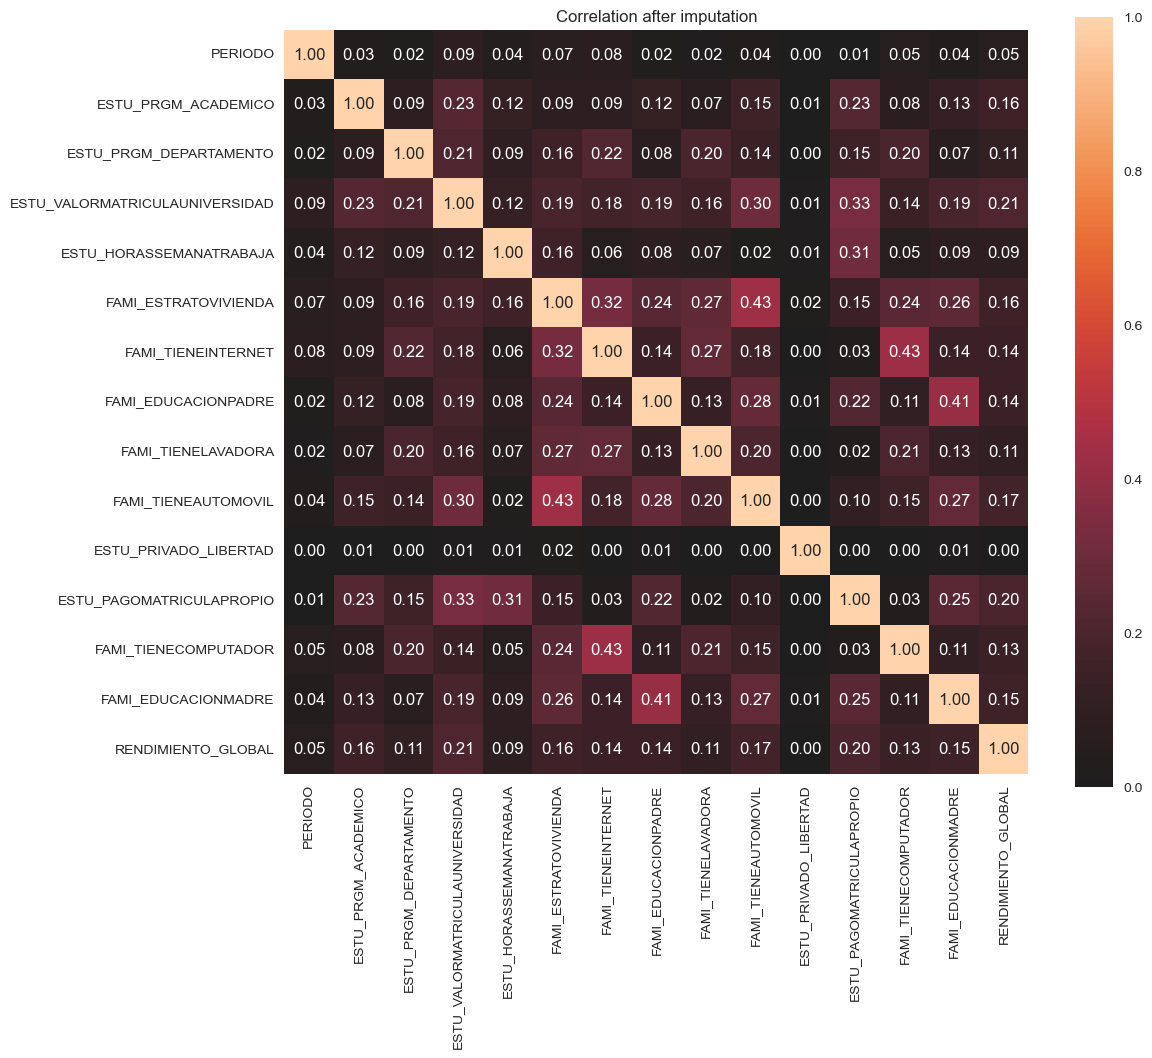

In [21]:
associations(df_train, title='Correlation after imputation', figsize=(12, 10))
plt.show()

#### Encoding
- Use **Target Encoding** on High Cardinality features
- Use **Ordinal Encoding** on `ESTRATO`, `EDUCACION`, `HORASTRABAJA`, `VALORMATRICULA`
- Use **One-Hot Encoding** on everything else

In [22]:
# Ordinal Encoding
custom_orders = [
    ['Sin Estrato', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6'],
    ['No trabaja', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas'],
    ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
    'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones', 'Entre 5.5 millones y menos de 7 millones',
    'Más de 7 millones'],
    ['Ninguno', 'Basica', 'Media', 'Superior'],
    ['Ninguno', 'Basica', 'Media', 'Superior']
]

ord_cols = ['FAMI_ESTRATOVIVIENDA','ESTU_HORASSEMANATRABAJA', 'ESTU_VALORMATRICULAUNIVERSIDAD',
           'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']

ordinal_encoder = OrdinalEncoder(categories=custom_orders)

df_ord_train = pd.DataFrame(ordinal_encoder.fit_transform(df_train[ord_cols]), columns=ord_cols)
df_ord_test = pd.DataFrame(ordinal_encoder.fit_transform(df_test[ord_cols]), columns=ord_cols)

# Join new cols and remove previous non encoded cols
df_train = pd.concat([df_train.drop(columns=ord_cols, axis=1), df_ord_train], axis=1)
df_test = pd.concat([df_test.drop(columns=ord_cols, axis=1), df_ord_test], axis=1)

In [23]:
# Label encoding
label_encoder = LabelEncoder()

new_labels = pd.DataFrame(label_encoder.fit_transform(df_train['RENDIMIENTO_GLOBAL']), columns=['RENDIMIENTO_GLOBAL'])
df_train = pd.concat([df_train.drop('RENDIMIENTO_GLOBAL', axis=1), new_labels], axis=1)

In [24]:
# Target encoding
hc_cols = ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO']

target_encoder = TargetEncoder(target_type='multiclass', random_state=RANDOM_SEED)
target_encoder.fit(df_train[hc_cols], df_train['RENDIMIENTO_GLOBAL'])
new_cols_names = target_encoder.get_feature_names_out()

high_cardinality_train = pd.DataFrame(target_encoder.transform(df_train[hc_cols]), columns=new_cols_names)
high_cardinality_test = pd.DataFrame(target_encoder.transform(df_test[hc_cols]), columns=new_cols_names)

# Remove old cols
df_train = pd.concat([df_train.drop(hc_cols, axis=1), high_cardinality_train], axis=1)
df_test = pd.concat([df_test.drop(hc_cols, axis=1), high_cardinality_test], axis=1)

In [25]:
# One-Hot Encoding
df_train = pd.get_dummies(df_train, dtype=int)
df_test = pd.get_dummies(df_test, dtype=int)

In [26]:
# Show preprocessed data
df_train.head()

,FAMI_ESTRATOVIVIENDA,ESTU_HORASSEMANATRABAJA,ESTU_VALORMATRICULAUNIVERSIDAD,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,ESTU_PRGM_ACADEMICO_0,ESTU_PRGM_ACADEMICO_1,ESTU_PRGM_ACADEMICO_2,ESTU_PRGM_ACADEMICO_3,...,FAMI_TIENELAVADORA_No,FAMI_TIENELAVADORA_Si,FAMI_TIENEAUTOMOVIL_No,FAMI_TIENEAUTOMOVIL_Si,ESTU_PRIVADO_LIBERTAD_N,ESTU_PRIVADO_LIBERTAD_S,ESTU_PAGOMATRICULAPROPIO_No,ESTU_PAGOMATRICULAPROPIO_Si,FAMI_TIENECOMPUTADOR_No,FAMI_TIENECOMPUTADOR_Si
0,3.0,1.0,6.0,2.0,3.0,2,0.167903,0.281386,0.271457,0.279252,...,0,1,0,1,1,0,1,0,0,1
1,3.0,0.0,4.0,3.0,2.0,1,0.290680,0.212757,0.260855,0.235708,...,0,1,1,0,1,0,1,0,0,1
2,3.0,4.0,4.0,2.0,2.0,1,0.288960,0.225324,0.254062,0.231654,...,0,1,1,0,1,0,1,0,1,0
3,4.0,0.0,5.0,0.0,2.0,0,0.148399,0.321586,0.233728,0.296286,...,0,1,1,0,1,0,1,0,0,1
4,3.0,3.0,4.0,1.0,1.0,3,0.184775,0.294671,0.238861,0.281692,...,0,1,0,1,1,0,1,0,0,1


## Feature Selection

At first, we are starting with filter methods.

In [41]:
# Split training data into features and target
X = df_train.drop('RENDIMIENTO_GLOBAL', axis=1)
y = df_train.RENDIMIENTO_GLOBAL

In [28]:
# selector = VarianceThreshold(0.01)
# X_selected = selector.fit_transform(X)
# X_selected = pd.DataFrame(X_selected, columns=selector.get_feature_names_out())
# X_selected

In [29]:
# selector = SelectKBest(score_func=chi2, k=25)
# X_selected = selector.fit_transform(X, y)
# X_selected = pd.DataFrame(X_selected, columns=selector.get_feature_names_out())
# X_selected

In [42]:
from prince import MCA

binary_cols = [col for col in X.columns if X[col].nunique() == 2]
mca = MCA(
    n_components=8,
    random_state=RANDOM_SEED,
    one_hot=False
)

new_cols = mca.fit_transform(X[binary_cols])
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.251,19.52%,19.52%
1,0.151,11.71%,31.23%
2,0.144,11.23%,42.46%
3,0.143,11.11%,53.57%
4,0.143,11.09%,64.66%
5,0.142,11.01%,75.68%
6,0.123,9.54%,85.21%
7,0.110,8.56%,93.77%


In [43]:
df_training = pd.concat([X.drop(binary_cols, axis=1), new_cols], axis=1)
df_training = pd.concat([df_training, y], axis=1)
df_training.shape

(692500, 22)

## Model Creation
Try new data with different models using **pycaret**

In [44]:
_ = setup(
    data=df_training,
    target='RENDIMIENTO_GLOBAL',
    session_id=RANDOM_SEED,
    preprocess=False
)

,Description,Value
0,Session id,42
1,Target,RENDIMIENTO_GLOBAL
2,Target type,Multiclass
3,Original data shape,"(692500, 22)"
4,Transformed data shape,"(692500, 22)"
5,Transformed train set shape,"(484749, 22)"
6,Transformed test set shape,"(207751, 22)"
7,Numeric features,21


In [45]:
best_model = compare_models(cross_validation=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.4211,0.6928,0.4211,0.4051,0.4088,0.2278,0.2295,3.0200
lightgbm,Light Gradient Boosting Machine,0.4210,0.6921,0.4210,0.4036,0.4069,0.2277,0.2298,3.4200
gbc,Gradient Boosting Classifier,0.4145,0.6852,0.4145,0.3974,0.4008,0.2189,0.2208,178.8000
ada,Ada Boost Classifier,0.4053,0.6664,0.4053,0.3861,0.3889,0.2065,0.2090,9.2900
lr,Logistic Regression,0.3874,0.6562,0.3874,0.3659,0.3659,0.1825,0.1862,13.8400
ridge,Ridge Classifier,0.3857,0.0000,0.3857,0.3596,0.3464,0.1798,0.1890,0.0900
rf,Random Forest Classifier,0.3715,0.6337,0.3715,0.3668,0.3688,0.1619,0.1620,7.7400
nb,Naive Bayes,0.3707,0.6450,0.3707,0.3621,0.3529,0.1600,0.1644,0.0600
et,Extra Trees Classifier,0.3680,0.6140,0.3680,0.3595,0.3625,0.1571,0.1575,12.1100
qda,Quadratic Discriminant Analysis,0.3596,0.6441,0.3596,0.3595,0.3300,0.1446,0.1554,0.1700


## Hyper-parameters Tuning

In [34]:
# from sklearn.model_selection import cross_val_score
# import optuna

In [35]:
# X = df_training.drop('RENDIMIENTO_GLOBAL', axis=1)
# y = df_training.RENDIMIENTO_GLOBAL

In [36]:
# def xgb_objective(trial):
    
#     # Create params
#     params = {
#         'n_estimators': trial.suggest_int('n_est', 100, 1500),
#         'learning_rate': trial.suggest_loguniform('lr', 1e-2, 0.1)
#     }
#     # Set params to the model and train the new model
#     best_model.set_params(**params)

#     # Calculate scores in 5 folds
#     scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

#     return np.mean(scores)

In [37]:
# study = optuna.create_study(direction='maximize')
# study.optimize(xgb_objective, n_trials=5)

[I 2024-05-18 20:40:55,788] A new study created in memory with name: no-name-9a238672-1a97-42d7-b3d3-8cec8d363edd
[I 2024-05-18 20:41:44,824] Trial 0 finished with value: 0.41861805054151624 and parameters: {'n_est': 264, 'lr': 0.03249351977537915}. Best is trial 0 with value: 0.41861805054151624.
[I 2024-05-18 20:44:20,569] Trial 1 finished with value: 0.42019927797833934 and parameters: {'n_est': 797, 'lr': 0.014847388977679777}. Best is trial 1 with value: 0.42019927797833934.
[I 2024-05-18 20:47:45,538] Trial 2 finished with value: 0.42199277978339345 and parameters: {'n_est': 1136, 'lr': 0.01834506878956942}. Best is trial 2 with value: 0.42199277978339345.
[I 2024-05-18 20:50:21,631] Trial 3 finished with value: 0.4218108303249098 and parameters: {'n_est': 886, 'lr': 0.021404521858568212}. Best is trial 2 with value: 0.42199277978339345.
[I 2024-05-18 20:52:21,403] Trial 4 finished with value: 0.42181227436823104 and parameters: {'n_est': 677, 'lr': 0.03199246787444728}. Best is 

In [38]:
# best_params = study.best_params
# best_params

{'n_est': 1136, 'lr': 0.01834506878956942}

## Making Predictions

In [39]:
# 'max_delta_step': trial.suggest_int('max_delta_step', 0, 20),
# 'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
# 'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.1, 1.0),
# 'colsample_bylevel': trial.suggest_loguniform('colsample_bylevel', 0.1, 1.0)
# 'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
# 'max_depth': trial.suggest_int('max_depth', 1, 50)
# {'n_est': 1084, 'lr': 0.09930447154713608}